In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import mord
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from plot_confusion import *

In [2]:
df = pd.read_csv('data/train.csv')
df_val = pd.read_csv('data/val.csv')

In [3]:
music = df.iloc[:,:19]
movies = df.iloc[:,19:31]
interests = df.iloc[:,31:63]
personality = df.iloc[:,63:]

music_val = df_val.iloc[:,:19]
movies_val = df_val.iloc[:,19:31]
interests_val = df_val.iloc[:,31:63]
personality_val = df_val.iloc[:,63:]


In [4]:
data = {'music':music,'movies':movies,'interests':interests,'personality':personality}
data_val = {'music':music_val,'movies':movies_val,'interests':interests_val,'personality':personality_val}


In [8]:
pca_proj = {}
pca_proj_val = {}

for k in data.keys():
    # Train
    means = np.mean( data[k] , axis = 0 )
    scaled = data[k] - means
    pca = PCA()
    pca.fit(scaled)
    projected = pca.transform(scaled)
    pca_proj[k] = projected
    
    # Validation
    
    scaled_val = data_val[k] - means
    pca_proj_val[k] = pca.transform(scaled_val)
    
    

In [99]:
# Threshholding

#First principal component

y_train , bins_train = pd.qcut( pca_proj['personality'][:,0]  , q = 5, labels = [1,2,3,4,5] , retbins=True)
y_val = pd.cut( pca_proj_val['personality'][:,0] , bins_train , right=True, labels=[1,2,3,4,5] )

y_train = np.array(y_train)
y_val = np.array(y_val)

x_train = np.concatenate( [ pca_proj['interests'][:,:10] , pca_proj['music'][:,:5] , pca_proj['movies'][:,:4]   ], axis=1)
x_val = np.concatenate( [ pca_proj_val['interests'][:,:10] , pca_proj_val['music'][:,:5] , pca_proj_val['movies'][:,:4]   ], axis=1)


## Ordinal Logistic Regression

### All-Threshold variant


 Training classification
Confusion matrix, without normalization
[[35 63 32 12  0]
 [ 9 56 50 24  2]
 [ 6 28 71 33  5]
 [ 2 16 51 57 13]
 [ 0 14 43 54 31]]


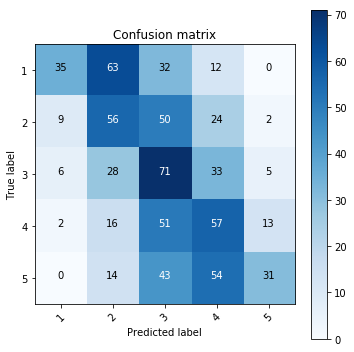


 Validation classification
Confusion matrix, without normalization
[[11 32 11  3  1]
 [ 7 20 20  9  1]
 [ 4  7 26 14  2]
 [ 0 10 14 20  6]
 [ 0  4  8 17  5]]


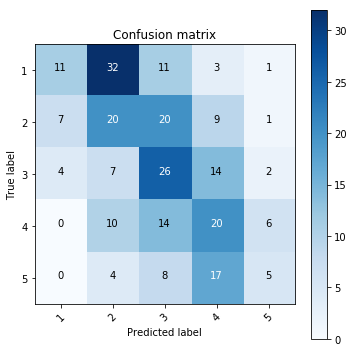

In [101]:
ord_logit = mord.LogisticAT(alpha=1.0)
ord_logit.fit(X = x_train, y = y_train )
y_pred = ord_logit.predict(x_train)
y_pred_val = ord_logit.predict(x_val)

print '\n Training classification'
plot_confusion_matrix( confusion_matrix( y_train , y_pred ) , classes=[1,2,3,4,5] ,size = 5)

print '\n Validation classification'
plot_confusion_matrix( confusion_matrix( y_val , y_pred_val ) , classes=[1,2,3,4,5] ,size = 5)


In [122]:
## AUC
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html


from sklearn import metrics

train_auc = []
val_auc = []


for i in [1,2,3,4,5]:
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred , pos_label=i)
    train_auc.append( metrics.auc(fpr, tpr) )
    
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_val , pos_label=i)
    val_auc.append( metrics.auc(fpr, tpr) ) 

In [127]:
print 'Train AUC per class'
print train_auc
print 'Validatoin AUC per class'
print val_auc

Train AUC per class
[0.22125763430138351, 0.38510262386286742, 0.50809031394137771, 0.65531588813456276, 0.7320578337280319]
Validatoin AUC per class
[0.23564699608958409, 0.39644624381466487, 0.56053854176543094, 0.67277227722772281, 0.73502428494333516]
